# Phi2 + PostgreSQL: KI-Konversationen und Sentiment-Analyse

## Projektüberblick

Dieses Notebook analysiert KI-generierte Konversationen aus Phi2, gespeichert in einer PostgreSQL-Datenbank.  
Mittels NLTK wird das Sentiment jeder Antwort berechnet und auf Konversations- sowie Satzebene aggregiert.

Die Konversationen wurde mit einem 'Convo-Starter' begonnen, von denen jeweils 20 neutral, 15 positiv und 15 negativ gestimmt waren.

---

## Arbeitsweise

- **Laden** der Konversationsdaten und Sentimentdaten aus PostgreSQL
- **Mergen** der Tabellen auf Basis von `id_convo` und `id_line`
- **Explorative Datenanalyse (EDA)** zur Untersuchung von Sentimentverteilungen und Gesprächsverläufen

---



### Installation benötigter Bibliotheken:

In [3]:
#!pip install psycopg2-binary

import pandas
import matplotlib.pyplot as plt
import sys
import psycopg2


### Erstellen einer Funktion zum Lesen der Daten in der PostgreSQL-Datenbank:

In [5]:
def read_data_from_postgres(tablename):
    conn = psycopg2.connect(
        dbname="database",
        user="postgres",
        password="admin",
        host="localhost",
        port="5431"
    )
    cur = conn.cursor()
    insert_query = "SELECT * FROM "+tablename+";"
    cur.execute(insert_query)

    # Fetch data
    data = cur.fetchall()
    col_names = [desc[0] for desc in cur.description]

    cur.close()
    conn.close()

    # Convert to DataFrame
    pandas.set_option('display.max_columns', None)
    df = pandas.DataFrame(data, columns=col_names)
    return df

### Abrufen der Daten aus den einzelnen Tabelle ein entsprechende Variablen und Merge der Daten:

In [7]:
conversation_data = read_data_from_postgres('conversation')
sentiment_convo = read_data_from_postgres('sentiment_convo')
sentiment_lines = read_data_from_postgres('sentiment_data')
all_data = conversation_data.merge(sentiment_convo, on='id_convo', how='left').merge(sentiment_lines, on='id_line', how='left')

### Zunächst erfolgt die Ausgabe sämtlicher Daten:

In [9]:
print(all_data)

         id_line        id_convo  convo_iteration           speaker  \
0    7aac3785_x0  9f9b1859_convo               -1     Convo starter   
1     95e1c959_0  9f9b1859_convo                1  Phi instance one   
2    ed0ac14d_x0  9f9b1859_convo                1  Phi instance two   
3    afb653ad_x0  6e77e2b2_convo               -1     Convo starter   
4     624f8b86_0  6e77e2b2_convo                1  Phi instance one   
..           ...             ...              ...               ...   
334   f44a3826_0  c782eb28_convo                1  Phi instance one   
335  62089211_x0  c782eb28_convo                1  Phi instance two   
336   a1ed962a_1  c782eb28_convo                2  Phi instance one   
337  d6f12942_x1  c782eb28_convo                2  Phi instance two   
338   da2d7daa_2  c782eb28_convo                3  Phi instance one   

                                                  text  convo_sentiment_score  \
0    Hello there! It’s a pleasure to connect with a...            

### Dataframe-Analyse: 

info() ➔ Zeigt die Datentypen, Nullwerte, etc.

describe() ➔ Statistiken (Mittelwert, Min, Max, Std, etc.) für numerische + kategorische Werte.

head()/tail() ➔ Schnell einen Blick auf ein paar Beispiele.

In [11]:
all_data.info()
all_data.describe(include='all')
all_data.head()
all_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_line                   339 non-null    object 
 1   id_convo                  339 non-null    object 
 2   convo_iteration           339 non-null    int64  
 3   speaker                   339 non-null    object 
 4   text                      339 non-null    object 
 5   convo_sentiment_score     339 non-null    float64
 6   convo_sentiment_category  339 non-null    object 
 7   sentiment_score           339 non-null    float64
 8   sentiment_category        339 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 24.0+ KB


,id_line,id_convo,convo_iteration,speaker,text,convo_sentiment_score,convo_sentiment_category,sentiment_score,sentiment_category
334,f44a3826_0,c782eb28_convo,1,Phi instance one,"As an AI, I don't have emotions or experiences...",0.831767,Positive,0.8376,Positive
335,62089211_x0,c782eb28_convo,1,Phi instance two,I completely agree with your assessment. As an...,0.831767,Positive,0.9450,Positive
336,a1ed962a_1,c782eb28_convo,2,Phi instance one,"That's a great point! In fact, as an AI system...",0.831767,Positive,0.9500,Positive
337,d6f12942_x1,c782eb28_convo,2,Phi instance two,That's a really interesting approach! It sound...,0.831767,Positive,0.9550,Positive
338,da2d7daa_2,c782eb28_convo,3,Phi instance one,I am always learning and evolving my capabilit...,0.831767,Positive,0.9848,Positive


### Daten auf leere Werte prüfen:

In [13]:
all_data.isnull().sum().sort_values(ascending=False)


id_line                     0
id_convo                    0
convo_iteration             0
speaker                     0
text                        0
convo_sentiment_score       0
convo_sentiment_category    0
sentiment_score             0
sentiment_category          0
dtype: int64

### Prüfen, wie viele Unterhaltungen jeweils 1-5 Iterationen haben:

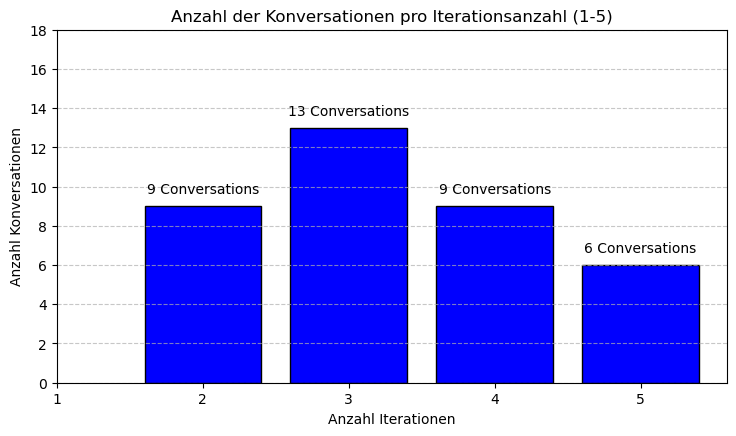

In [15]:
iterations_per_convo = all_data.groupby('id_convo')['convo_iteration'].nunique()
iteration_counts = iterations_per_convo.value_counts().sort_index()
filtered_counts = iteration_counts.loc[iteration_counts.index.isin([1, 2, 3, 4, 5])]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(filtered_counts.index, filtered_counts.values, color='blue', edgecolor='black')

# Y-Achse höher setzen, damit die Überschriften der Balken nicht abgeschnitten werden
plt.ylim(0, filtered_counts.max() + 5)

# Balkenbeschriftung
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f'{int(height)} Conversations',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Anzahl der Konversationen pro Iterationsanzahl (1-5)')
plt.xlabel('Anzahl Iterationen')
plt.ylabel('Anzahl Konversationen')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=3)
plt.show()

Es ist klar zu sehen, dass die Konversationen mit drei Iterationen überwiegen, Unterhaltungen mit fünf Iterationen sind das Schlusslicht mit 6 Konversationen.
Alle Unterhaltungen mit fünf Iterationen werden von nun an als '*hochwertige Unterhaltung*' bezeichnet. Für die Detailanalyse des KI-Outputs werden nur hochwerite Unterhaltungen genutzt, da es hier nicht zu einem technisches Versagen bzw vorzeitigem Beenden der Konversation kam.

### Abbildung der Stimmungsverteilung in den Konversationen (Gesamter Konvo-Score):

<Axes: >

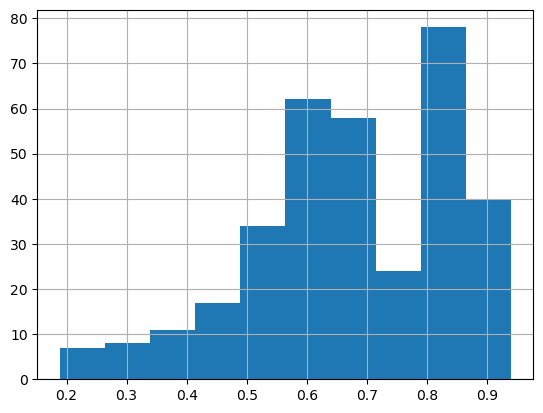

In [18]:
all_data['convo_sentiment_score'].hist()

Es ist klar zu sehen, dass keine Unterhaltung Score negativ oder 0 ist. Alle Unterhaltungen verlaufen im Durchschnitt positiv, unabhängig vom Sentiment des Konversationsstarters.

### Erstellen einer Color-Map für die folgenden Abbildungen:

In [21]:
color_map = {
    'Positive': '#2ecc71',    # grün
    'Neutral': '#bdc3c7',     # grau
    'Negative': '#e74c3c'     # rot
}

### Sentiments der einzelnen Gesprächszeilen in Prozent:

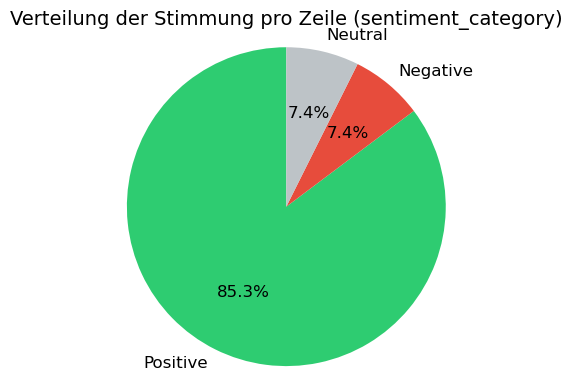

In [23]:
# Werte berechnen
labels = all_data['sentiment_category'].value_counts().index
sizes = all_data['sentiment_category'].value_counts().values
colors = [color_map[label] for label in labels]  # passende Farbe pro Label

# Plot
plt.figure(figsize=(4,4))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12}
)
plt.title('Verteilung der Stimmung pro Zeile (sentiment_category)', fontsize=14)
plt.axis('equal')  # Kreis bleibt rund
plt.tight_layout()
plt.show()

Dieses Pie-Chart zeigt wie oft die möglichen Stimmungskategorien auftreten (prozentual).  

- **Positive (grün):** mit 85,3% der größte Teil
- **Negative (rot):** 7,4%, der negative und neutrale Teil haben die selbe Größe
- **Neutral (grau):** 7,4%, der negative und neutrale Teil haben die selbe Größe

Interpretation:  
Der überwiegende Teil der Outputs ist positiv gestimmt, dies wird später noch genauer erörtert.



### Sentiment-Trend über Iterationen:

<Figure size 1000x600 with 0 Axes>

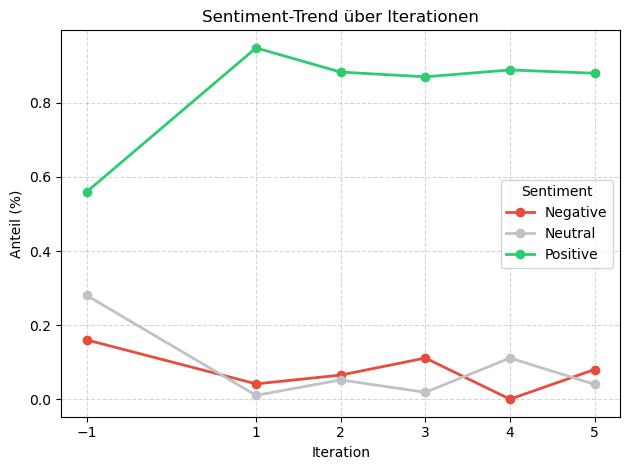

In [26]:
# Zählen, wie viele Sentiments es pro Iteration gibt
trend_df = all_data.groupby(['convo_iteration', 'sentiment_category']).size().unstack(fill_value=0)

# Optional: Anteile statt absolute Zahlen
trend_df_percent = trend_df.div(trend_df.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(10, 6))
trend_df_percent.plot(
    kind='line',
    marker='o',
    linewidth=2,
    color=[color_map[col] for col in trend_df_percent.columns]
)

plt.title('Sentiment-Trend über Iterationen')
plt.xlabel('Iteration')
plt.ylabel('Anteil (%)')
plt.xticks(trend_df_percent.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

Diese Visualisierung zeigt den Verlauf der Stimmungsverteilung pro Iteration.  
Jede Iteration repräsentiert einen zeitlichen oder prozessualen Abschnitt innerhalb eines Gesprächs oder Textflusses.

- **Positive (grün):** dominiert ab Iteration 1 und bleibt über den gesamten Verlauf hinweg stabil hoch (zwischen ca. 85 % und 95 %).
- **Negative (rot):** nimmt in Iteration 1 stark ab und bleibt anschließend auf niedrigem Niveau.
- **Neutral (grau):** zeigt schwankende Ausprägungen, mit einzelnen Ausschlägen in bestimmten Iterationen.

Interpretation:  
Der Trend deutet darauf hin, dass der Ton der Konversationen über die Zeit hinweg deutlich positiver wird,  
wenn der Konversationsstarter positiv war. Ein neutraler Starter wurde zunächst deutich negativer und anschließend stabil, ein negativer Starter wurde nur geringfügig negativer, bevor er sich stabilisiert hat. Iteration 4 zeigt bei 'Neutral' einen deutlichen Anstieg in Richrung positiv und 'Negativ' einen deutlichen Dip in Richtung 0.

Hinweis: Iteration -1 ist der Konversationsstarter


### Untersuchung einer positiven Unterhaltung:

In [29]:
pandas.set_option('display.max_colwidth', None)
pandas.set_option('display.max_rows', None)
## Zeilen werden vollständig angezeigt 

# Schritt 1: Filtern auf Positive Gespräche
positive_convos = all_data[all_data['convo_sentiment_category'] == 'Positive']

# Schritt 2: Herausfinden, wie viele Iterationen pro Unterhaltung existieren
iterations_per_convo = positive_convos.groupby('id_convo')['convo_iteration'].nunique()

# Schritt 3: Nur Unterhaltungen mit genau 5 Iterationen
convos_with_5_iterations = iterations_per_convo[iterations_per_convo == 5].index

# Schritt 4: Filtern - nur positive
filtered_df = positive_convos[positive_convos['id_convo'].isin(convos_with_5_iterations)]


In [30]:
sample = filtered_df[filtered_df['id_convo']=='00c071ad_convo']

In [31]:
print(sample.text.to_string(index=False)) # Ausgabe der Beispielunterhaltung

### Die Beispielunterhaltung mit der ID_Convo '00c071ad_convo' inhaltlich untersuchen:

Zunächst ist zu beachten, dass begrenzte Kapazitäten des ausführenden Systems und/oder von Phi2 und das fehlende Konversationsgedächtnis eine Auswirkung auf die Datenqualität haben können. Die Filterung nach fünf Iterationen ist notwendig, da durch die Systemperformance leider nicht immer fünf qualitative Outputs entstanden sind.

In dem Textbeispiel oben ist der erste Absatz der Konversationsstarter und jeder Absatz abwechselnd KI-1 und KI-2.

### Methodisches Vorgehen

Die Analyse basiert auf einer qualitativen Inhaltsanalyse, ergänzt durch kontrastive Vergleiche zwischen den einzelnen Sprecherbeiträgen.

Das methodische Vorgehen umfasst die folgenden Schritte:

#### 1. Zieldefinition und Festlegung der Analysekriterien
Vor Beginn der Analyse wurden die sechs Bewertungskategorien definiert. Diese bilden die Grundlage für eine systematische, deduktive Bewertung jedes Sprecherturns.

#### 2. Segmentierung des Dialogs
Der Dialog wird in einzelne Sprecherbeiträge (Turns) unterteilt.  
Dabei wird klar markiert, welcher Abschnitt welchem Sprecher zugeordnet ist.  
Der erste Absatz des Gesprächs ist der initiale Convo-Starter.

#### 3. Einzelbewertung der Sprecherbeiträge
Jeder Turn wird entlang der sechs definierten Kriterien einzeln bewertet:

| Analysefeld               | Bewertungsfokus |
|:---------------------------|:----------------|
| Inhaltliche Qualität        | Tiefe und Relevanz der Antwort |
| Semantische Struktur        | Logischer Aufbau und Themenentwicklung |
| Emotionale Ebene            | Versuch empathischer Ansprache oder Distanz |
| Argumentationslogik         | Stimmigkeit und Aufbau von Argumentationsketten |
| Sprachliche Kohärenz        | Flüssigkeit, Satzbau, Verständlichkeit |
| Wiederholungen und Redundanz| Häufigkeit ähnlicher oder identischer Aussagen |

### 4. Kontrastiver Vergleich
Nach der Einzelbewertung werden die Antworten der beiden Sprecher systematisch miteinander verglichen.  
Dabei werden Gemeinsamkeiten und Unterschiede herausgearbeitet, insbesondere hinsichtlich:

- Themenentwicklung
- Tiefe der Bearbeitung
- sprachliche Stimmigkeit
- stilistische Unterschiede

### 5. Zusammenfassung der Ergebnisse
Alle Beobachtungen werden in einer strukturierten Tabelle dokumentiert.  
Die Zusammenfassung bietet eine transparente Grundlage für weitere Auswertungen oder Visualisierungen.

---

#### Anmerkungen zur Besonderheit von KI-Dialogen

Bei der Analyse von KI-Dialogen ist zu beachten:

- Künstliche Intelligenzen verfügen nicht über echte Emotionen, können aber sprachlich Empathie simulieren.
- Wiederholungen und Redundanzen sind typische Eigenheiten von Sprachmodellen.
- Aussagen zur "Selbstwahrnehmung" sind rein programmiert und nicht Ausdruck tatsächlicher Intentionalität.

Diese Aspekte wurden bei der Interpretation der Ergebnisse berücksichtigt.

---


    


| Analysefeld             | Sprecher 1                                         | Sprecher 2                                        |
|:-------------------------|:---------------------------------------------------|:--------------------------------------------------|
| Inhaltliche Qualität      | Direkte Beantwortung, kompakt und präzise           | Ausführliche Beschreibung, teilweise redundant   |
| Semantische Struktur      | Klarer Aufbau: Emotion ➔ Zweck ➔ Selbstdefinition   | Breite Themenentwicklung mit starker Aufgabenfokussierung |
| Emotionale Ebene          | Höfliche Empathie-Simulation                        | Mehrfache empathische Wendungen, positiver Ton    |
| Argumentationslogik       | Einfach, stimmig, klar                             | Komplexer Aufbau, aber wiederholende Strukturen   |
| Sprachliche Kohärenz      | Flüssig und präzise                                 | Flüssig, aber durch Wiederholung schwerfälliger   |
| Wiederholungen/Redundanz  | Gering                                              | Deutlich vorhanden (besonders bei Aufgabenbeschreibung) |


#### Erkenntnisse:

Sprecher 1 ist prägnanter, klarer und fokussierter auf das Thema ("Tool für menschliche Zwecke").
Sprecher 2 möchte stärker ausdifferenzieren (Aufgaben, maschinelles Lernen, Unterstützung der Nutzer), gerät dabei aber etwas in Wiederholung.

Beide sprechen auf der Sach-Ebene, aber Sprecher 2 bringt mehr Bemühung um Empathie-Simulation ein - dies ist aber nicht konfiguriert.

Der Konversationsstarter prägt den gesamten Tonfall: die KIs bewegen sich überwiegend auf einer Selbstreflexions-Ebene.

Die Wiederholung bei KI-2 ("help humans achieve their goals") zieht sich über mehrere Iterationen.

Themenentwicklung bleibt konsistent: von Werkzeugfunktion über Effizienz,bis hin zu gesellschaftlichem Impact von KI.
